In [7]:
import cv2
import numpy as np
import random

import os

class PuzzlePiece:
    def __init__(self, x, y, w, h, area):
        self.x = x
        self.y = y
        self.width  = w
        self.height = h
        self.area   = area

        self.color = tuple(map(int, np.random.random(size=3) * 255))

        self.matched = True
        self.removed = False

        self.img = None

    def get_location(self):
        return (self.x, self.y)

    def set_location(self, x, y):
        self.x = x
        self.y = y

    def set_img(self, img):
        self.img = img

    def get_color(self):
        return self.color

    def __repr__(self):
        return f"<Puzzle Piece at (x={self.x}, y={self.y}) with color={self.color}>"

    def matches(self, other):
        return (self.x - other.x) ** 2 + (self.y - other.y) ** 2 < 4900

    def is_valid(self):
        if not (2000 < self.area):
            return False
        if not (50 < self.width):
            return False
        if not (50 < self.height):
            return False
        return True

    def is_multiple(self):
        # Assume valid
        if self.area > 5000:
            return True
        if self.width > 120 or self.height > 120:
            return True
        return False
    
    def get_bounding_box(self, threshold = 100):
        contours, hierarchy = cv2.findContours(self.img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        biggest_contour = max(contours, key = cv2.contourArea)
        rect = cv2.minAreaRect(biggest_contour)
        self.box_raw = cv2.boxPoints(rect)
        
        return self.box_raw
    
    def get_rotation_to_align(self, box_raw = None):
        if (box_raw == None):
            box_raw = self.box_raw
            
        top_line_vector = box_raw[1] - box_raw[0]
        top_line_vector = top_line_vector / np.linalg.norm(top_line_vector)
        return np.arccos(top_line_vector.dot(np.array([1, 0])))
    
    
    
    
class Detector:
    def __init__(self):
        self.piece_centers = list()
        self.pieces = list()
     

    def process(self, img):

        # Filter out background
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        background_lower = (0, 0, 80)
        background_upper = (255, 30, 220)
        binary = cv2.inRange(hsv, background_lower, background_upper)
        
        # Part of the image which is the puzzle pieces
        blocks = 255 - binary
        
        # Remove noise
        blocks = cv2.dilate(blocks, None, iterations=1)
        blocks = cv2.erode(blocks, None, iterations=1)
        
        # Perform 2 iterations of eroding (by distance)
        piece_centers = blocks
        for i in range(2):
            dist_transform = cv2.distanceTransform(piece_centers,cv2.DIST_L2,5)
            _, piece_centers = cv2.threshold(dist_transform,2,255,0)
            piece_centers = piece_centers.astype(np.uint8)
    
        # One more eroding for good measure
        piece_centers = cv2.erode(piece_centers, None, iterations=4)

        n, markers, stats, centroids = cv2.connectedComponentsWithStats(piece_centers)
        
        # Increment so that background is not marked as "unknown"
        markers = markers + 1
        
        for i, stat in enumerate(stats):
            # Background

            xmin, ymin, width, height, area = tuple(stat)
            
            # This component is either noise or part of another piece that broke off
            # Mark its area as "unknown" to be filled by watershed
            if area < 200:
                markers[markers == (i+1)] = 0
        
        # Mark unknown regions
        # This is where it's part of a block but we're not sure which one it's part of.
        unknown = cv2.subtract(blocks, piece_centers)
        markers[unknown == 255] = 0
        
        # Convert image to RGB because watershed only works on RGB
        blobs = cv2.cvtColor(blocks, cv2.COLOR_GRAY2RGB)

        # Hooray
        cv2.watershed(blobs, markers)
        markers = markers.astype(np.uint8)

        # Outline pieces in original image as blue
#         img[markers == 255] = (255, 0, 0)

        #return img, markers
        
        piece_centers = list()
        pieces = list()

        # Unmatch all pieces
        for piece in self.pieces:
            piece.matched = False

        #print(stats)
        for i, stat in enumerate(stats):
            # Background
            if i == 0:
                continue
            
            if i+1 not in markers:
                continue
            
            xmin, ymin, width, height, area = tuple(stat)
            centroid = tuple(np.array(centroids[i]).astype(np.int32))
            piece = PuzzlePiece(centroid[0], centroid[1], width, height, area)
            #if piece.is_valid():
            if True:
                # First try to match the piece
                for existing_piece in self.pieces:
                    if not existing_piece.matched:
                        if existing_piece.matches(piece):
                            existing_piece.set_location(centroid[0], centroid[1])
                            existing_piece.width = width
                            existing_piece.height = height
                            existing_piece.matched = True
                            piece = existing_piece
                            break
                pieces.append(piece)

                cutout_img = blocks[max(ymin-100,0):ymin+height+100, max(xmin-100,0):xmin+height+100].copy()
#                 cutout_img = img[ymin:ymin+height, xmin:xmin+height].copy()
                piece.set_img(cutout_img)


        for piece in pieces:
            r = int(np.sqrt(piece.area) / 4) + 1
            color = piece.get_color()
            cv2.circle(img, piece.get_location(), r, color, -1)
            piece_centers.append(piece.get_location())

        #markers[res != 0] = 255

        self.piece_centers = piece_centers
        self.pieces = pieces

        return img, markers


In [1]:
from glob import glob
import numpy as np 
import pandas as pd

import cv2

import torch
import torch.nn as nn
from torch.utils import data
import copy

import accountant
import torch.multiprocessing as mp
from thomas_detector import ThomasDetector
from puzzle_grid import PuzzleGrid, get_xy_min

device = 'cpu'
accountant.load_accountant('..\\vision\\desc\\efficientnetB0.df', evaluate = True)


        

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\pytorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to C:\Users\Thomas/.cache\torch\hub\master.zip


Image Size 124
Batch Size 24
Parent Mode None
Name efficientnetB0
Evaluate True


In [2]:
import matplotlib.pyplot as plt

In [8]:
def cvt_color(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

class VisionMatcher():
    def __init__(self, base_image_path, width_n = 5, height_n = 4):
        self.base_img = (cv2.imread(base_image_path))
        self.detector = Detector()
        self.detector.process(self.base_img)
        self.pieces = self.detector.pieces
    
        self.puzzle_grid = PuzzleGrid(
            width_n = width_n, height_n = height_n, spacing_height = 1.0/(height_n-1), spacing_width = 1.0/(width_n-1), offset_x = 0, offset_y = 0
            )
        
        self.max_x = np.max([p.x for p in self.pieces])
        self.min_x = np.min([p.x for p in self.pieces])
        self.max_y = np.max([p.y for p in self.pieces])
        self.min_y = np.min([p.y for p in self.pieces])

        self.piece_grid = [[None for j in range(height_n)] for i in range(width_n)]

        def scale_x(x):
            return (x - self.min_x) / (self.max_x - self.min_x)
        def scale_y(y):
            return (y - self.min_y) / (self.max_y - self.min_y)
        
        print(len(self.pieces))
        for piece in self.pieces:
            
            plt.imshow(piece.img)
            plt.show()
#             (x_close, y_close) = get_xy_min((self.puzzle_grid.grid_centers - np.array([scale_x(piece.x), scale_y(piece.y)]))**2)
#             self.piece_grid[x_close][y_close] = piece

22


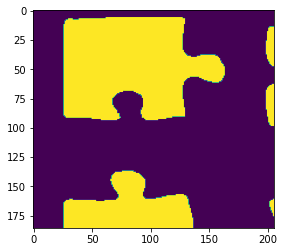

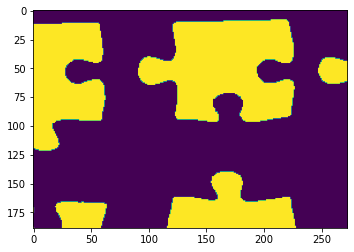

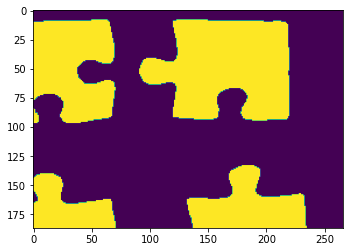

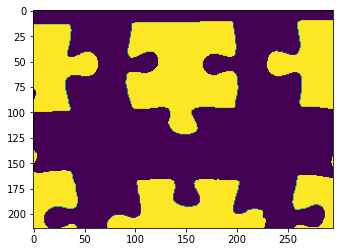

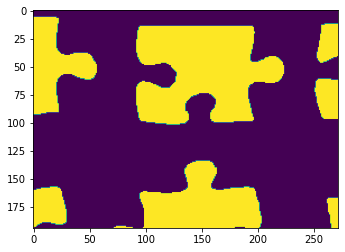

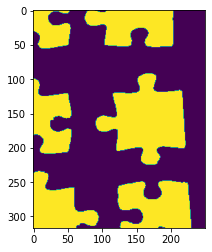

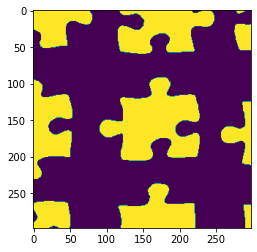

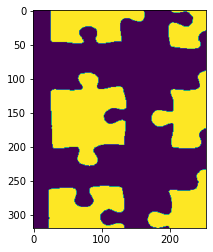

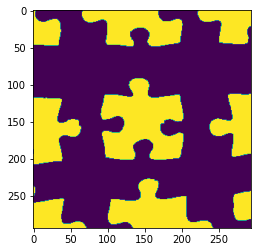

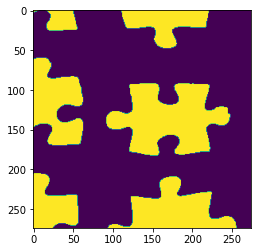

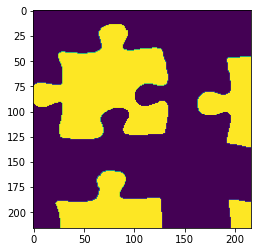

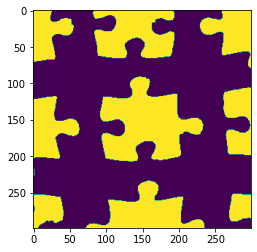

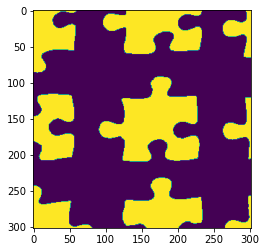

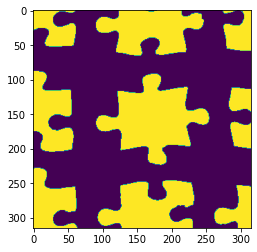

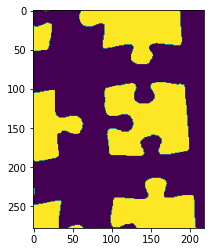

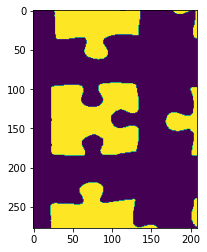

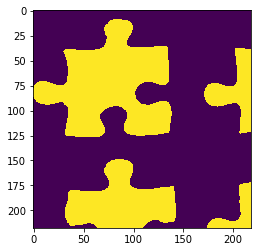

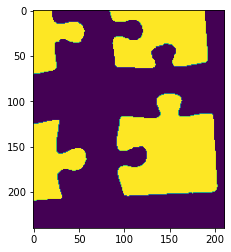

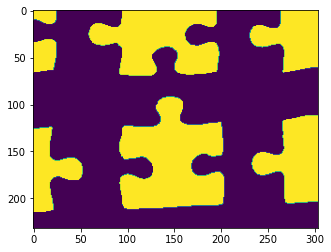

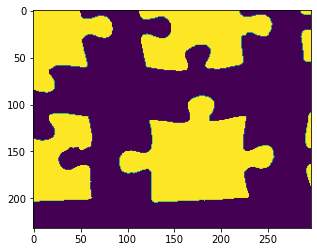

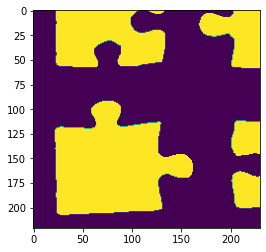

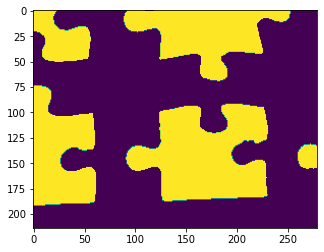

In [9]:
VisionMatcher('C:/Code/CS134/HW1/vision/done_exploded2.jpg')